# Wstęp do uczenia maszynowego
##  Praca domowa nr 2
#### Jakub Piwko, Malwina Wojewoda
***
***
***

### Pakiety

In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
np.random.seed(23)
from sklearn.model_selection import train_test_split
from sklearn import metrics
from unidecode import unidecode

### Wczytanie i analiza danych

Zbiór danych opisuje transakcje zarejestrowane na stronie allegro.pl w ciągu jednego pełnego dnia 3 kwietnia 2016r. 
Zmienna, którą przewidujemy: cena

In [3]:
df = pd.read_csv('allegro-api-transactions.csv')
df.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"


### Podział na zbiór treningowy, testowy i walidacyjny

In [89]:
#Wyróżnienie zbioru, na którym będziemy pracować i zbioru do walidacji
X, X_valid = sklearn.model_selection.train_test_split(
    df,
    test_size=0.30, random_state=100)

#Wyróżnienie zbioru treningowego i testowego
X_train, X_test = sklearn.model_selection.train_test_split(
    X,
    test_size=0.30, random_state=100)

#### Analiza braków danych

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205809 entries, 258810 to 414402
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lp                      205809 non-null  int64  
 1   date                    205809 non-null  object 
 2   item_id                 205809 non-null  int64  
 3   categories              205809 non-null  object 
 4   pay_option_on_delivery  205809 non-null  int64  
 5   pay_option_transfer     205809 non-null  int64  
 6   seller                  205809 non-null  object 
 7   price                   205809 non-null  float64
 8   it_is_allegro_standard  205809 non-null  int64  
 9   it_quantity             205809 non-null  int64  
 10  it_is_brand_zone        205809 non-null  int64  
 11  it_seller_rating        205809 non-null  int64  
 12  it_location             205809 non-null  object 
 13  main_category           205809 non-null  object 
dtypes: float64(1), 

W ramce danych nie wystąpują wartości None/Null, więc nie będziemy musieli zajmować się uzupełnianiem brakujących wartości.

#### Rozkłady zmiennych
Pomimo, że niektóre zmienne są typu *int* i *float*, to mogą to być zmienne dyskretne/kategoryczne. Sprawdźmy to zatem:

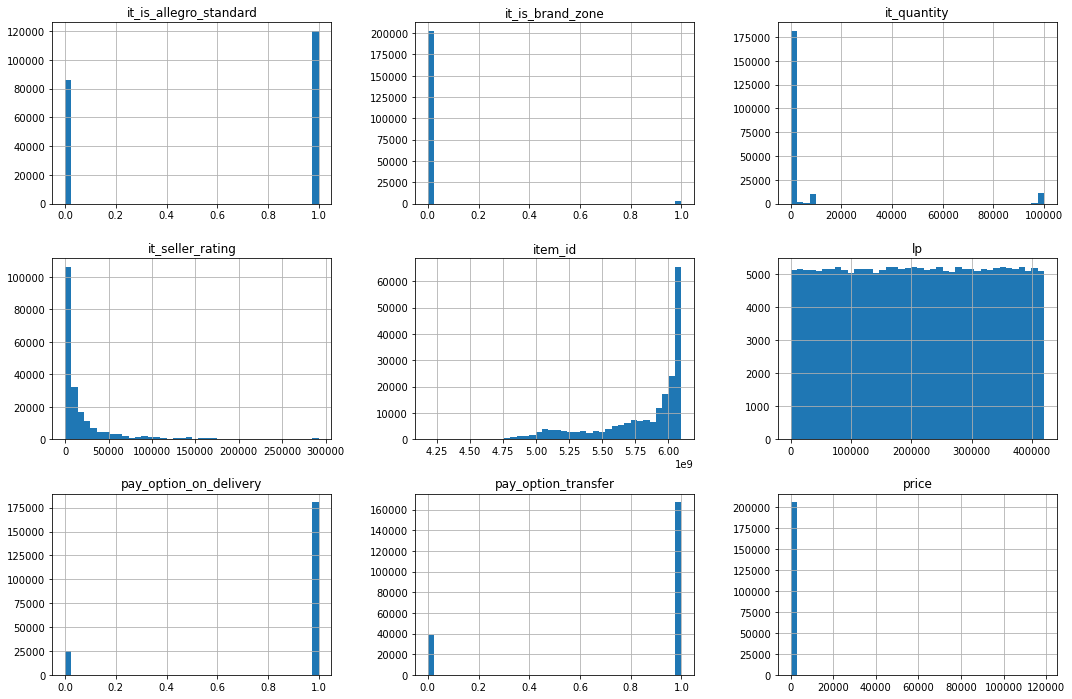

In [6]:
X_train.hist(figsize=(18, 12), bins=40)
plt.show()

Mimo, że z histogramu niektóre wielkości wyglądają na kategoryczne, lepiej upewnic się, korzystając ze zliczenia występujących wartości:

In [6]:
X_train['pay_option_on_delivery'].value_counts()

1    180652
0     25157
Name: pay_option_on_delivery, dtype: int64

In [7]:
X_train['pay_option_transfer'].value_counts()

1    167212
0     38597
Name: pay_option_transfer, dtype: int64

In [8]:
X_train['it_is_allegro_standard'].value_counts()

1    120044
0     85765
Name: it_is_allegro_standard, dtype: int64

In [9]:
X_train['it_is_brand_zone'].value_counts()

0    202406
1      3403
Name: it_is_brand_zone, dtype: int64

In [10]:
X_train['it_quantity'].value_counts()

0        31216
1         5532
2         4191
3         3554
4         3345
         ...  
2882         1
2905         1
48642        1
49997        1
96822        1
Name: it_quantity, Length: 6241, dtype: int64

Widać więc, że zmienne `pay_option_on_delivery`, `pay_option_transfer`, `it_is_allegro_standard`, `it_is_brand_zone` są kategoryczne z dwiema wartościami: 0 i 1. Natomiast zmienna `it_quantity` okazała się być ciągła.

### Zamiana zmiennych ciągłych na kategoryczne

Zmienna `item_id` to numer identyfikujący konketną rzecz, który nie ma żadnego wpływu na nasza zmienną celu, dlatego można usunąć tę kolumnę. Podobnie kolumna `lp` jest identyfikatorem zamówienia i nie wnosi żadnej informacji. Do zmiany pozostają zatem tylko zmienne `it_quantity`,  `it_seller_rating` oraz `price`.

In [90]:
X_train.drop(['item_id', 'lp'],  axis=1, inplace = True)

####  `it_quantity`

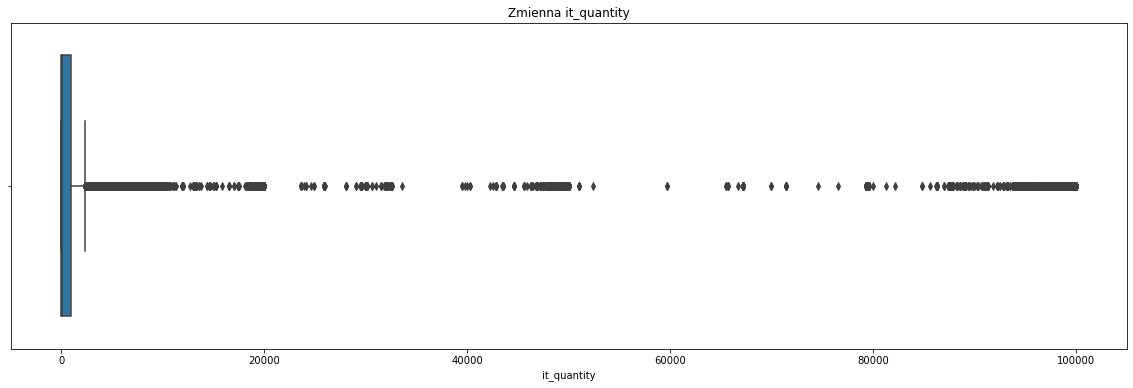

In [8]:
plt.figure(figsize=(20, 6))
box_plot = sns.boxplot(X_train['it_quantity'])
box_plot.set_title('Zmienna it_quantity')
plt.show()

In [9]:
X_train['it_quantity'].max()

99999

Jako, że zmienna `it_quantity` mówi nam o tym, ile egzemplarzy danego produktu ktoś kupił, możemy podzielić go na 5 kategorii, które odpowiadają kwintylom: 

In [91]:
X_train['it_quantity'] = pd.qcut(X_train['it_quantity'], 5, labels=[1, 2, 3, 4, 5])

#### `it_seller_rating`

Text(0.5, 1.0, 'Zmienna it_seller_rating')

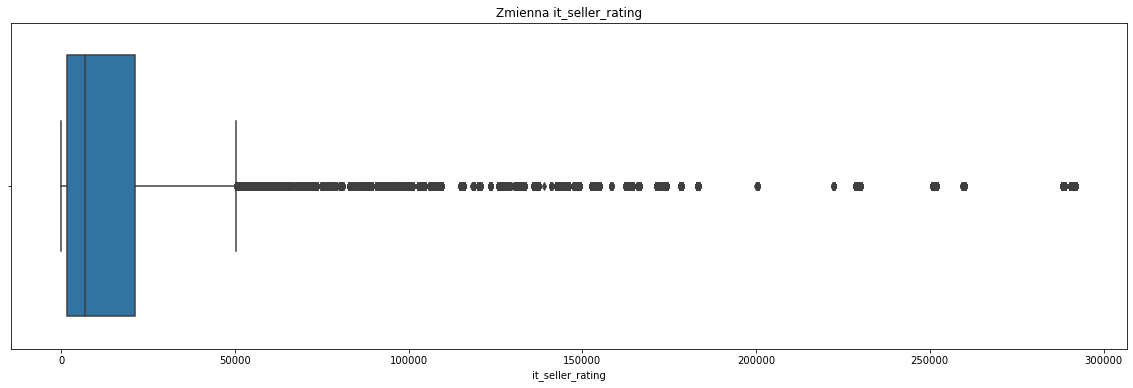

In [11]:
plt.figure(figsize=(20, 6))
box_plot = sns.boxplot(X_train['it_seller_rating'])
box_plot.set_title('Zmienna it_seller_rating')

In [12]:
X_train["it_seller_rating"].describe()

count    205809.000000
mean      20485.224801
std       36916.108466
min          -1.000000
25%        1577.000000
50%        6709.000000
75%       21051.000000
max      292074.000000
Name: it_seller_rating, dtype: float64

In [13]:
X_train[X_train.seller == "ezebra_pl"][['seller', 'it_seller_rating']]

,seller,it_seller_rating
387776,ezebra_pl,95755
319097,ezebra_pl,95775
198298,ezebra_pl,95782
335130,ezebra_pl,95271
91461,ezebra_pl,94531
...,...,...
64397,ezebra_pl,95458
349837,ezebra_pl,95766
387729,ezebra_pl,95743
130334,ezebra_pl,95769


Jako, że zmienna `it_seller_rating` mówi nam o ocenie sprzedającego. Jak widać na powyższej tabeli, dla jednego konretnego sprzedającego, rating nie zmienia się w ciągu dnia. Klienci oceniają sprzedawcę między transakcjami, ale ocena nie zmienia się drastycznie. 

In [21]:
X_train[X_train.it_seller_rating < 0]

,date,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
258120,2016-04-03 16:24:32,"['Odzież, Obuwie, Dodatki', 'Obuwie', 'Damskie...",1,0,Galaktykastylu16,86.99,0,1,0,-1,Wola Radziszowska,"Odzież, Obuwie, Dodatki"
258119,2016-04-03 23:51:10,"['Odzież, Obuwie, Dodatki', 'Obuwie', 'Damskie...",1,0,Galaktykastylu16,86.99,0,1,0,-1,Wola Radziszowska,"Odzież, Obuwie, Dodatki"
69151,2016-04-03 19:26:59,"['Motoryzacja', 'Opony', 'Opony dostawcze', 'L...",1,0,Grzesiek4423,400.00,0,1,0,-1,Choroszcz,Motoryzacja
79733,2016-04-03 20:33:47,"['Gry', 'Gadżety', 'Pozostałe']",0,0,Kajman997,2.00,0,5,0,-1,Szczecinek,Gry


Najpierw zauważamy, że niektóre rekordy mają wartość oceny ustawioną na -1, co można traktować jako brak oceny. Jako, że są to tylko 4 takie obserwacje, pozbędziemy się ich z zestawu. 

In [92]:
X_train = X_train[X_train.it_seller_rating != -1]

Dane ciągłe z kolumny `it_seller_rating` możemy podzielić go na 5 kategorii, które odpowiadają kwintylom: 

In [93]:
X_train['it_seller_rating'] = pd.qcut(X_train['it_seller_rating'], 5, labels=[1, 2, 3, 4, 5])

In [25]:
X_train['it_seller_rating'].value_counts()

3    41183
2    41172
1    41168
5    41157
4    41125
Name: it_seller_rating, dtype: int64

#### `price`

Text(0.5, 1.0, 'Zmienna price')

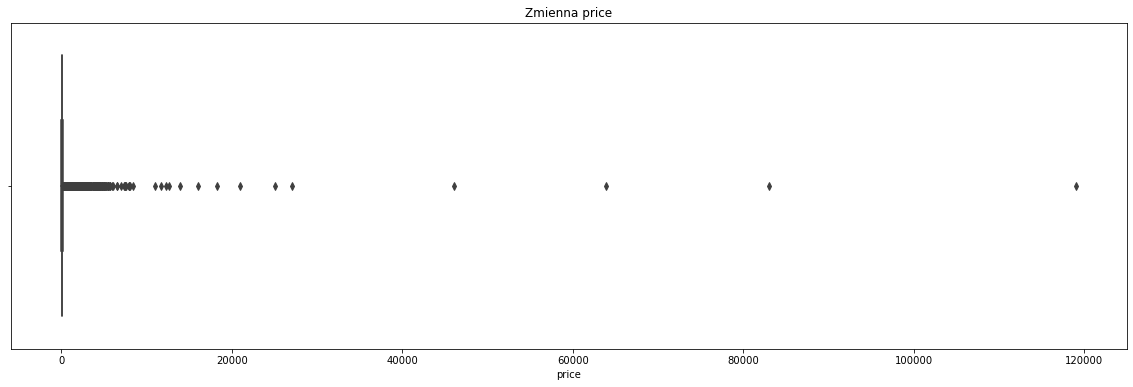

In [27]:
plt.figure(figsize=(20, 6))
box_plot = sns.boxplot(X_train['price'])
box_plot.set_title('Zmienna price')

Jeśli mamy podzielić zmienną *price* na 3 kategorie: cena wysoka, cena średnia oraz cena niska, to widać, że dane większe niż 10000 będą z pewnością zaliczać się do ostaniej grupy, ponieważ są to wartości odstające. 

In [28]:
X_train['price'].describe()

count    205805.000000
mean         76.937907
std         432.170195
min           0.000000
25%           9.000000
50%          24.990000
75%          68.000000
max      119000.000000
Name: price, dtype: float64

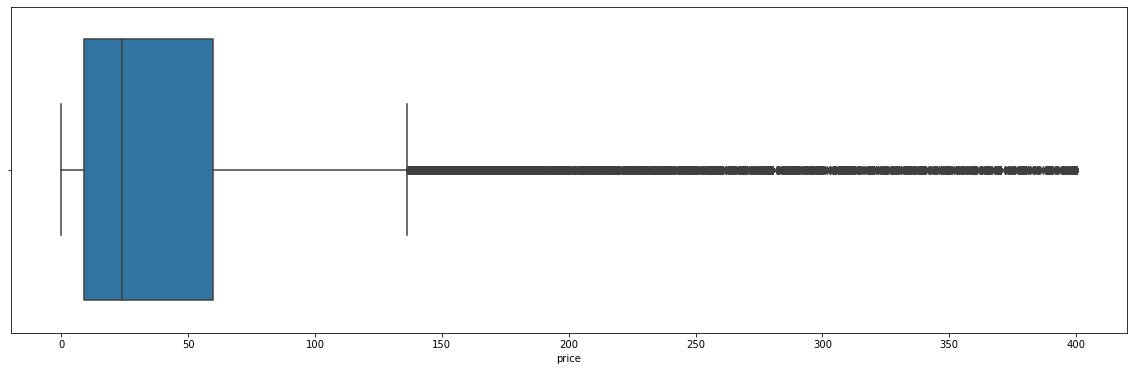

In [29]:
plt.figure(figsize=(20, 6))
tmp = X_train.loc[X_train['price'] < 400]
box_plot = sns.boxplot(tmp['price'])

In [30]:
np.percentile(X_train['price'], 90)

168.7

In [31]:
np.percentile(X_train['price'], 60)

35.0

Podział ceny zależy w dużej mierze od celu binzesowego naszego modelu. Bez określonego celu podział staje się kwestią subiektywną. My podzielimy zmienną ceny następująco:
* 0-35 - produkty tanie
* 35 - 150 - średnio drogie
* \> 150 - drogie

In [94]:
tmp = pd.cut(X_train['price'], bins=[0, 35, 150, np.inf], labels=[1, 2, 3])

In [27]:
# sprawdzamy czy przy takim podziale wstąpią jakieś braki dnaych
tmp[tmp.isna()]

206090    NaN
247789    NaN
127751    NaN
58547     NaN
8433      NaN
336570    NaN
224534    NaN
328635    NaN
182919    NaN
45669     NaN
201684    NaN
346869    NaN
12741     NaN
320207    NaN
417758    NaN
379219    NaN
Name: price, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [28]:
#sprawdzamy dlaczego wystapiły
X_train.loc[379219, 'price']

0.0

Nie wiadomo jak interpretować cenę wynoszącą 0, zatem ze względu na to, że wartości tych jest stosunkowo niewiele lepiej je usunąć.

In [95]:
X_train = X_train[X_train.price != 0]

In [96]:
X_train['price'] = pd.cut(X_train['price'], bins=[0, 35, 150, np.inf], labels=[1, 2, 3])

### Kodowanie zmiennych kategorycznych

Jak wynika już z wcześniejszej analizy, zmienne `pay_option_on_delievery`, `pay_option_delievry`, `it_is_allegro_standar`, `it_is_brand_zone` są kategoryczne. Przyjrzyjmy się innym zmiennym.

Na pierwszy rzut oka wydaje się, że zmienne `categories` i `main_category` niosą podobną informację. 

In [64]:
X_train['main_category'].value_counts()

Dom i Ogród                            44689
Odzież, Obuwie, Dodatki                26746
Motoryzacja                            22369
Dla Dzieci                             20506
Uroda                                  13775
Sport i Turystyka                      13496
RTV i AGD                               9926
Telefony i Akcesoria                    9725
Komputery                               7103
Zdrowie                                 6489
Książki i Komiksy                       5708
Delikatesy                              3902
Gry                                     3526
Rękodzieło                              3246
Kolekcje                                3008
Przemysł                                2909
Biżuteria i Zegarki                     2829
Biuro i Reklama                         1575
Fotografia                              1163
Muzyka                                   941
Antyki i Sztuka                          563
Konsole i automaty                       525
Filmy     

In [39]:
X_train.loc[X_train.main_category == "Motoryzacja"]['categories'].value_counts()

['Motoryzacja', 'Opony', 'Opony samochodowe', 'Letnie']                                                                        1224
['Motoryzacja', 'Części samochodowe', 'Oświetlenie', 'Żarówki']                                                                 561
['Motoryzacja', 'Akcesoria samochodowe', 'Dywaniki', 'Dywaniki gumowe']                                                         249
['Motoryzacja', 'Akcesoria samochodowe', 'Dywaniki', 'Dywaniki welurowe']                                                       248
['Motoryzacja', 'Chemia', 'Oleje silnikowe', 'Syntetyczne']                                                                     202
                                                                                                                               ... 
['Motoryzacja', 'Części samochodowe', 'Układ elektryczny, zapłon', 'Wyposażenie elektryczne', 'Silniczki regulacji fotela']       1
['Motoryzacja', 'Narzędzia i sprzęt warsztatowy', 'Sprzęt warsztatowy', 'Meb

Okazuje się, że zmienna `categories` jest rozszerzeniem zmiennej `main_category`. Wydaje się, więc że ze względu na duże rozdrobnienie lepiej będzie usunąć zmienną `categories` i pozostawić bardziej ogólną zmienną. 

In [97]:
X_train.drop('categories', axis = 1, inplace = True)

Dodatkowo, można popracować nad redukcją różnych kategorii w zmiennej `main_category`. Wydaje się, że niektóre kategorie dotyczą podobnych produktów, dzięki czemu możliwe jest ich scalenie. 
* Na początek do grupy 'RTV i AGD' dodamy też grupy 'telefony i akcesoria', 'Komputery', 'Konsole i automaty' i 'Sprzęt estradowy, studyjny i DJ-ski'.
* Kategorie 'Książki i komiksy', 'Gry', 'Rękodzieło', 'Kolekcje', 'Fotografia', 'Muzyka', 'Antyki i Sztuka', 'Filmy', 'Instrumenty' połączymy w jedną kategorię 'Rozrywka i sztuka'.
* Kategorię 'Biżuteria i `zegarki' dołączymy do kategorii 'Odzież, obuwie, dodatki'.
* Kategorię 'Uroda' i 'Zdrowie' połączymy w kategorię 'Uroda i zdrowie'
* Kategorie 'Delikatesy', 'Przemysł', 'Biuro i Reklama', 'Bilety' i 'Nieruchomości' połączymy w grupę "Przemysł i usługi"

In [98]:
rtv = ['Komputery', 'Telefony i Akcesoria', 'Konsole i automaty', 'Sprzęt estradowy, studyjny i DJ-ski']
art = ['Książki i Komiksy', 'Gry', 'Rękodzieło', 'Kolekcje', 'Fotografia', 'Muzyka', 'Antyki i Sztuka', 'Filmy', 'Instrumenty']
ind = ['Delikatesy', 'Przemysł', 'Biuro i Reklama', 'Bilety', 'Nieruchomości']

X_train['main_category'] = X_train['main_category'].replace(rtv, 'RTV i AGD')
X_train['main_category'] = X_train['main_category'].replace(art,'Sztuka i Rozrywka')
X_train['main_category'] = X_train['main_category'].replace('Biżuteria i Zegarki','Odzież, Obuwie, Dodatki')
X_train['main_category'] = X_train['main_category'].replace(['Uroda', "Zdrowie"],'Uroda i Zdrowie')
X_train['main_category'] = X_train['main_category'].replace(ind,'Przemysł i usługi')

In [42]:
X_train['main_category'].value_counts()

Dom i Ogród                44689
Odzież, Obuwie, Dodatki    29575
RTV i AGD                  27479
Motoryzacja                22369
Dla Dzieci                 20506
Uroda i Zdrowie            20264
Sztuka i Rozrywka          18966
Sport i Turystyka          13496
Przemysł i usługi           8445
Name: main_category, dtype: int64

#### `date`

Dane w naszej ramce pochodzą z jednego konretnego dnia, 3 kwietnia 2016 roku. Dlatego wydaje się, że można ze zmiennej `date` wyciągnąć informacje o godzinie i umieścić w zmiennej 'time' informującej o godzinie dokonania zakupu. Następnie można pogrupować uczynić zmienną 'type' kategoryczną dzieląc na 4 grupy:

* 0:00 - 6:00 - 1 jako 'noc'
* 6:00 - 12:00 - 2  jako 'ranek'
* 12:00 - 18:00 - 3 jako 'popołudnie'
* 18:00 - 24:00 - 4 jako 'wieczór'

Dodatkowo można pozbyć się kolumny 'date'.

In [99]:
X_train['date'] = pd.to_datetime(X_train['date'])
X_train['time'] = X_train['date'].apply(lambda x:x.time())
X_train['time'] = X_train['time'].apply(lambda x:x.hour)
X_train['time'] = pd.cut(X_train['time'], bins=[-1, 5, 11, 17, 24], labels=[1, 2, 3, 4])
X_train.drop('date', axis = 1, inplace = True)

#### `location`

Ze względu na dużą ilość rekordów zliczymy wystąpienia danych lokalizacji i wybierzemy te występujące najczęściej. 

In [68]:
tmp = X_train.groupby(['it_location']).size().reset_index(name='counts').sort_values(by = 'counts', ascending=False)
tmp[tmp.counts > 1000]

,it_location,counts
5898,Warszawa,11226
2527,Kraków,7514
7670,Łódź,5358
4205,Poznań,5174
6237,Wrocław,4244
367,Białystok,3584
2916,Lublin,3224
4713,Rzeszów,2936
2299,Kielce,2827
995,Częstochowa,2762


Widać, że znaczenie ma wielkość liter, więc dla ujednolicenia zamienimy wszytstkie litery na duże i usuniemy polskie znaki.


In [100]:
X_train['it_location'] = X_train['it_location'].str.upper()
X_train['it_location'] = X_train['it_location'].apply(unidecode)

In [101]:
tmp = X_train.groupby(['it_location']).size().reset_index(name='counts').sort_values(by = 'counts', ascending=False)
tmp[tmp.counts > 1000]

,it_location,counts
5125,WARSZAWA,13057
2109,KRAKOW,8450
2489,LODZ,6348
3704,POZNAN,5650
1493,INTERNET,5496
5530,WROCLAW,4941
256,BIALYSTOK,4792
2611,LUBLIN,3575
4151,RZESZOW,3386
1844,KIELCE,3154


Widać, że w powyższej tabeli miejsca oznaczone jako **INTERNET**, **SPRZEDAZ WYSYLKOWA**, **CALA POLSKA**, **POLSKA** mogą być potraktowane jako jedna kategoria, którą nazwiemy **WYSYLKA**. Wszystkie pozostałe lokalizaje oznaczymy jako **OTHERS**.

In [102]:
X_train['it_location'] = X_train['it_location'].replace(['INTERNET', 'SPRZEDAZ WYSYLKOWA', 'CALA POLSKA', 'POLSKA'],'WYSYLKA')

In [103]:
others = X_train['it_location'].value_counts()[X_train['it_location'].value_counts() < 1000].index
X_train['it_location'] = np.where(X_train['it_location'].isin(others), 'OTHERS', X_train['it_location'])

#### `seller`

Każdy sklep ma wstawioną oceną, którą już skategoryzowaliśmy, dlatego nazwa sklepu już nic nie wnosi, dlatego ją usuwamy.

In [104]:
X_train.drop('seller', inplace = True, axis = 1)

### Zamiana zmiennych na numeryczne
Na koniec, aby w ramce mieć jedynie zmienne numeryczne, użyjemy `LabelEncoder` oraz one-hot-encoding, aby zakodować dzieki temu pozostałe zmienne tesktowe.

In [105]:
cat_df = pd.get_dummies(X_train['main_category'], prefix='cat_')
cat_df.shape

(205789, 9)

In [106]:
X_train.shape

(205789, 10)

In [107]:
# mają tyle samo wierszy więc łączenie obu ramek:
X_train = pd.concat([X_train, cat_df], axis=1)
X_train

,pay_option_on_delivery,pay_option_transfer,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category,time,cat__Dla Dzieci,cat__Dom i Ogród,cat__Motoryzacja,"cat__Odzież, Obuwie, Dodatki",cat__Przemysł i usługi,cat__RTV i AGD,cat__Sport i Turystyka,cat__Sztuka i Rozrywka,cat__Uroda i Zdrowie
258810,1,1,2,1,1,0,1,OTHERS,Motoryzacja,4,0,0,1,0,0,0,0,0,0
365240,1,1,1,1,3,0,5,OTHERS,Dom i Ogród,2,0,1,0,0,0,0,0,0,0
271612,1,1,2,0,5,0,2,KIELCE,Dom i Ogród,4,0,1,0,0,0,0,0,0,0
271568,1,1,1,1,2,0,1,KRAKOW,Uroda i Zdrowie,3,0,0,0,0,0,0,0,0,1
99302,1,1,2,1,1,0,3,LODZ,"Odzież, Obuwie, Dodatki",3,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381825,1,0,2,0,4,0,2,OTHERS,Uroda i Zdrowie,4,0,0,0,0,0,0,0,0,1
294111,1,1,3,1,2,0,5,WARSZAWA,Dla Dzieci,2,1,0,0,0,0,0,0,0,0
197946,1,1,1,1,5,0,5,RADOM,Dla Dzieci,4,1,0,0,0,0,0,0,0,0
125128,1,1,1,0,4,0,1,OTHERS,Motoryzacja,4,0,0,1,0,0,0,0,0,0


In [108]:
local_df = pd.get_dummies(X_train['it_location'], prefix='loc_')

In [109]:
X_train = pd.concat([X_train, local_df], axis=1)
X_train.drop(['it_location', 'main_category'],  axis=1, inplace = True)

In [110]:
X_train.head()

,pay_option_on_delivery,pay_option_transfer,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,time,cat__Dla Dzieci,cat__Dom i Ogród,...,loc__OTHERS,loc__POZNAN,loc__RADOM,loc__RZESZOW,loc__SZCZECIN,loc__TORUN,loc__WARSZAWA,loc__WROCLAW,loc__WYSYLKA,loc__ZIELONA GORA
258810,1,1,2,1,1,0,1,4,0,0,...,1,0,0,0,0,0,0,0,0,0
365240,1,1,1,1,3,0,5,2,0,1,...,1,0,0,0,0,0,0,0,0,0
271612,1,1,2,0,5,0,2,4,0,1,...,0,0,0,0,0,0,0,0,0,0
271568,1,1,1,1,2,0,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
99302,1,1,2,1,1,0,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0


### Podsumowanie wprowadzonych zmian

* usunięcie kolumn `item_id`, `lp` , `categories`, `seller`
* zamiana ciągłej zmiennej `it_quantity` na 5 kategorii ponumerowanych kolejnymi liczbami naturalnymi oznaczającymi, w którym kwartylu znajduje się dana wartość
* zamiana ciągłej zmiennej `price` na 3 kategorie ponumerowane kolejnymi liczbami naturalnymi, gdzie 1 oznacza niską cenę, 2 - średnią, a 3 - wysoką
* usunięcie wierszy, dla których `it_seller_rating` = -1 oraz tych, gdzie `price` = 0
* redukcja unikalnych wartości kolumny `categories` a następnie przekształcenie tej kolumny na zmienną liczbową przy pomocy one-hot encoding
* zamiana w kolumne `date` z godzin na 4 pory dnia oznaczane numerami, usunięcie daty
* w kolumnie `location` wybranie miejsc, z których było ponad 1000 ofert, pozostałe zgrupowanie do *Others*, następnie przekształcenie tej kolumny na zmienną liczbową przy pomocy one-hot encoding, jednak jest to bardzo niedokładne zgupowanie, ponieważ niektóre miasta wpisane są jako cały adres, albo dzielnice, więc tym samym wpadły do kategorii *Others*. 

### Zmiany w zbiorze testowym

Przeprowadzimy teraz te same zmiany w zbiorze testowym

In [111]:
X_test.drop(['item_id', 'lp'],  axis=1, inplace = True)
X_test['it_quantity'] = pd.qcut(X_test['it_quantity'], 5, labels=[1, 2, 3, 4, 5])
X_test = X_test[X_test.it_seller_rating != -1]
X_test['it_seller_rating'] = pd.qcut(X_test['it_seller_rating'], 5, labels=[1, 2, 3, 4, 5])
X_test = X_test[X_test.price != 0]
X_test['price'] = pd.cut(X_test['price'], bins=[0, 35, 150, np.inf], labels=[1, 2, 3])
X_test.drop('categories', axis = 1, inplace = True)

X_test['main_category'] = X_test['main_category'].replace(rtv, 'RTV i AGD')
X_test['main_category'] = X_test['main_category'].replace(art,'Sztuka i Rozrywka')
X_test['main_category'] = X_test['main_category'].replace('Biżuteria i Zegarki','Odzież, Obuwie, Dodatki')
X_test['main_category'] = X_test['main_category'].replace(['Uroda', "Zdrowie"],'Uroda i Zdrowie')
X_test['main_category'] = X_test['main_category'].replace(ind,'Przemysł i usługi')

X_test['date'] = pd.to_datetime(X_test['date'])
X_test['time'] = X_test['date'].apply(lambda x:x.time())
X_test['time'] = X_test['time'].apply(lambda x:x.hour)
X_test['time'] = pd.cut(X_test['time'], bins=[-1, 5, 11, 17, 24], labels=[1, 2, 3, 4])
X_test.drop('date', axis = 1, inplace = True)

X_test['it_location'] = X_test['it_location'].str.upper()
X_test['it_location'] = X_test['it_location'].apply(unidecode)
X_test['it_location'] = X_test['it_location'].replace(['INTERNET', 'SPRZEDAZ WYSYLKOWA', 'CALA POLSKA', 'POLSKA'],'WYSYLKA')
others = X_test['it_location'].value_counts()[X_test['it_location'].value_counts() < 1000].index
X_test['it_location'] = np.where(X_test['it_location'].isin(others), 'OTHERS', X_test['it_location'])

X_test.drop('seller', inplace = True, axis = 1)

cat_df = pd.get_dummies(X_test['main_category'], prefix='cat_')
X_test = pd.concat([X_test, cat_df], axis=1)

local_df = pd.get_dummies(X_test['it_location'], prefix='loc_')
X_test = pd.concat([X_test, local_df], axis=1)
X_test.drop(['it_location', 'main_category'],  axis=1, inplace = True)

In [115]:
X_test.head()

,pay_option_on_delivery,pay_option_transfer,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,time,cat__Dla Dzieci,cat__Dom i Ogród,cat__Motoryzacja,...,loc__KIELCE,loc__KRAKOW,loc__LODZ,loc__LUBLIN,loc__OTHERS,loc__POZNAN,loc__RZESZOW,loc__WARSZAWA,loc__WROCLAW,loc__WYSYLKA
3010,1,1,0,4,0,1,4,1,0,0,...,0,0,0,0,1,0,0,0,0,0
299769,1,0,1,1,0,1,4,1,0,0,...,0,0,1,0,0,0,0,0,0,0
150362,1,1,0,1,0,3,4,0,0,0,...,0,0,0,0,1,0,0,0,0,0
259319,1,1,1,5,0,3,4,0,0,0,...,0,0,0,0,1,0,0,0,0,0
277629,1,1,0,3,0,4,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Wstępne modele    

Przetestujemy teraz bazowe modele na prztworzonych zbiorach

In [112]:
#Wyciągnięcie zmiennej przewidywanej ze zbiorów
y_train = np.array(X_train['price'])
X_train = X_train.drop(['price'],axis=1)
y_test = np.array(X_test['price'])
X_test = X_test.drop(['price'],axis=1)

In [113]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=100, multi_class = 'multinomial')

lr.fit(X_train, y_train)
y_hat = lr.predict(X_train)
print('y:     ' + str(y_hat[0:20]) + '\ny_hat: ' + str(y_train[0:20]))

y:     [2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1]
y_hat: [2 1 2 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1]


In [84]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_hat)

0.6235853228306664

In [128]:
lr.fit(X_test, y_test)
y_hatt = lr.predict(X_test)
accuracy_score(y_test, y_hatt)

0.6204773513237712

In [118]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)
y_hat = tree.predict(X_train)
print('y:     ' + str(y_hat[0:20]) + '\ny_hat: ' + str(y_train[0:20]))

y:     [2 2 2 1 2 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1]
y_hat: [2 1 2 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1]


In [119]:
accuracy_score(y_train, y_hat)

0.7064274572499016

In [130]:
tree.fit(X_test, y_test)
y_hatt = tree.predict(X_test)
print('y:     ' + str(y_hat[0:20]) + '\ny_hat: ' + str(y_test[0:20]))

y:     [2 2 2 1 2 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1]
y_hat: [2 1 1 1 1 3 3 1 1 1 2 1 1 1 1 2 2 2 1 1]


In [131]:
accuracy_score(y_test, y_hatt)

0.7093599410397415

Dla najprostszej regresji logistycznej zarówno dla zbioru treningowe i testowego dokładność jest na poziomie 0.62. Przy użyciu drzewa decyzyjnego wynik jest już na poziomie 0.7. Choć jest wyższy to nadal jest nad czym pracować. Mimo to, oba wyniki są zadowlające jak na bazowy model. Na pewno dają możliwości dalszych poprawek danych i doboru regulujących hiperparametrów. 